# 1.import libraries

In [1]:
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import pandas as pd 
import random
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from colorama import Fore
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import math

cpu


# 2. import data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# attention !!
#  if you are using google colab to run the code : change the following line to your own google drive (where you upload the data)
#  if you are running the code on your own computer : comment line 8 by adding # at its beginning
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
%cd '/content/gdrive/MyDrive/my_code/41river'
df = pd.read_excel('Ghalefor.xlsx')

Mounted at /content/gdrive/
/content/gdrive/MyDrive/my_code/41river


In [4]:
# To increase accuracy, we added the rainfall of the day before and two days 
#prior to the data as well to examine its potential impact on the flow rate 
df['yesterday_rain'] = df['Rain'].shift(1)
df['yesterday_rain'][0] =0
df['two_days_ago']= df['Rain'].shift(2)
df['two_days_ago'][0] = 0
df['two_days_ago'][1] = 0
df

,Rain,Flow,yesterday_rain,two_days_ago
0,0.0,1.670,0.0,0.0
1,0.0,1.670,0.0,0.0
2,0.0,1.670,0.0,0.0
3,0.0,1.670,0.0,0.0
4,0.0,1.670,0.0,0.0
...,...,...,...,...
13144,0.0,0.725,0.0,0.0
13145,1.0,0.801,0.0,0.0
13146,0.0,0.801,1.0,0.0
13147,0.0,0.885,0.0,1.0


# 3. visulazing data

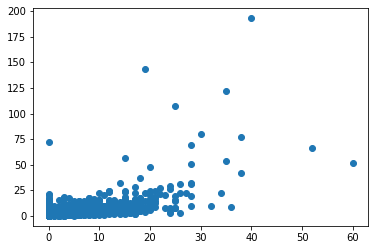

In [5]:
plt.scatter(df['Rain'], df['Flow'])

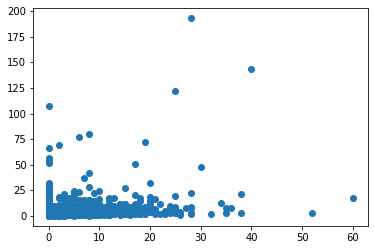

In [6]:
plt.scatter(df['yesterday_rain'], df['Flow'])

There isn't necessarily a direct relationship between rainfall and flow rate. Even on days with zero rainfall, the flow rate can vary significantly.

# 4. preparing data

In [85]:
train, test = train_test_split( df, test_size=0.2, random_state=42,shuffle=True)
print('train.shape',train.shape)
print('test.shape',test.shape)
total_traing = train.shape[0]
total_test = test.shape[0]


train.shape (10519, 4)
test.shape (2630, 4)


In [8]:
class MyDataset(Dataset):
 
  def __init__(self,data): 

    self.x=torch.Tensor(data.drop(columns = ['Flow']).values)
    
    self.y=torch.tensor(data['Flow'].values)

  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.x[idx].float(),self.y[idx].float()

In [9]:
def creating_loaders(BATCH_size,train,test):
  train_dataset = MyDataset(train)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_size,shuffle=True)
  test_dataset = MyDataset(test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_size,shuffle=True)
  return (train_loader,test_loader)

# 5. neural network model

In [10]:
# Using this class, we can build a neural network for various values of layers and activation functions 
class Network(nn.Module):
    def __init__(self,layers_neourons,acivation_functions):
        
        super().__init__()
        layers = []
        for i in range(len(layers_neourons)-1):
          L1 = nn.Linear(layers_neourons[i],layers_neourons[i+1])
          
          if acivation_functions[i] =='relu':
            act= nn.ReLU()
            
          if acivation_functions[i] =="tanh":
             act= nn.Tanh()
          if acivation_functions[i] =="sigmoid":
            act= nn.Sigmoid()
          if acivation_functions == None:
             layers.append(L1)
          layers.append(L1)
          layers.append(act)
        self.linears = nn.ModuleList(layers)
        
       

        

    def forward(self,x): 
      for i, l in enumerate(self.linears):
        x = l(x)
                     
      return x
        


# 6.training the model

In [11]:
# The Loss function here is considered to be the L1 loss function. This is because this function has better ability to mitigate the undesirable effects of outliers on the model compared to the mean squared error function
# loss_func = nn.MSELoss()
loss_func =nn.L1Loss()

In [12]:
def train_one_epoch(model,train_data_loader,optimizer,epoch_index):
    training_loss = 0
    for i, data in enumerate(train_data_loader ,0):
      
        optimizer.zero_grad()          
        X_train,y_train = data
        X_train,y_train= X_train.to(device),y_train.to(device)
        y_train = torch.unsqueeze(y_train,1) 
        outputs = model(X_train)
        loss_1 = loss_func(outputs,y_train)  
        training_loss   +=  loss_1.item() 
        
        loss_1.backward()       
        optimizer.step()
 
    return  training_loss/ (i+1)

In [13]:
def train_model(model,optimizer,EPOCHS,BATCH_size,start_time,train_data_loader, test_data_loader):
  loss_train_list=[]
  loss_test_list=[]
  for epoch in range(EPOCHS):
      
      model.train(True)  
      traing_avg_loss = 0
      traing_avg_loss = train_one_epoch(model,train_data_loader,optimizer,epoch)
      loss_train_list.append(traing_avg_loss)
      model.train(False)
      running_vloss = 0.0    
      for i, vdata in enumerate(test_data_loader,0 ):
          with torch.no_grad():
            X_test,y_test = vdata
            X_test,y_test =  X_test.to(device),y_test.to(device)
            voutputs=  model( X_test)
            y_test = torch.unsqueeze(y_test,1) 
            vloss = loss_func(voutputs, y_test)
            running_vloss += vloss.item()
            
      test_avg_loss = running_vloss/ (i+1)
      loss_test_list.append(test_avg_loss)
      now = time.time()-start_time
      if (epoch+1)%5 ==0 and epoch!=0:
              print(Fore.BLACK,'train set loss: {}, test_set loss: {} in epoch {}/{} ,time is: {}sec'.format('%.5f' % traing_avg_loss,'%.5f' % test_avg_loss,epoch+1,EPOCHS,'%.1f' % now))   
  return(loss_train_list,loss_test_list)


In [14]:
#   In this section, we create several different structures of neural networks and perform training and 
# testing operations on them. We will then select the best model from the available options.

start_time = time.time()
best_test_loss = 100000000
different_model_loss = []
model_parameters = []
model_num = 0
EPOCHS  =30
BATCH_size = 32
train_data_loader, test_data_loader =  creating_loaders(BATCH_size,train,test)
layers_neourons = [[3,30,1],[3,5,1],[3,10,1],[3,15,1],[3,20,1],[3,25,1],[3,5,4,1],[3,10,5,1],[3,20,10,1],[3,25,15,1],[3,18,12,1],[3,15,8,3,1]]
acivation_functions_2 =[['relu',None],['sigmoid',None],['tanh',None]]
acivation_functions_3 = [['relu','relu',None],['sigmoid','sigmoid',None],['tanh','tanh',None]]
acivation_functions_4 = [['relu','relu','relu',None],['sigmoid','sigmoid','sigmoid',None],['tanh','tanh','tanh',None]]
for i in range(len(layers_neourons)):
  if len(layers_neourons[i])==3:
    acivation_functions =acivation_functions_2
  elif  len(layers_neourons[i])==4:
    acivation_functions =acivation_functions_3
  elif len(layers_neourons[i])==5:
    acivation_functions =acivation_functions_4
  
  for j in range(len(acivation_functions)):
    print(Fore.RED+'model number is {},model hidden layrs are {} and coresponding activation funcitions are{}'.format(model_num,layers_neourons[i][1:-1],acivation_functions[j][:-1]))
    model = Network(layers_neourons[i],acivation_functions[j])
    model.to(device)
    



    optimizer =  optim.SGD(model.parameters(), lr = 0.0001 )
    traing_avg_loss,test_avg_loss = train_model(model,optimizer,EPOCHS,BATCH_size,start_time,train_data_loader, test_data_loader)


    different_model_loss.append(test_avg_loss[-1])
    info = {}
    info['layers'] = layers_neourons[i]
    info['activation'] = acivation_functions[j][:-1]
    model_parameters.append(info)

    model_num+=1
    if test_avg_loss[-1]<best_test_loss:
      print(Fore.GREEN+'this is the best model yet')
      print(Fore.GREEN+'-----------------------------')
      best_model = model 
      best_test_loss = test_avg_loss[-1]
      
      best_model_train_loss = traing_avg_loss
      best_model_test_loss =  test_avg_loss
    del model
 


model number is 0,model hidden layrs are [30] and coresponding activation funcitions are['relu']
 train set loss: 1.85083, test_set loss: 1.79214 in epoch 5/30 ,time is: 1.2sec
 train set loss: 1.74087, test_set loss: 1.73706 in epoch 10/30 ,time is: 2.3sec
 train set loss: 1.72225, test_set loss: 1.71770 in epoch 15/30 ,time is: 3.4sec
 train set loss: 1.71591, test_set loss: 1.70890 in epoch 20/30 ,time is: 4.4sec
 train set loss: 1.71251, test_set loss: 1.70161 in epoch 25/30 ,time is: 5.5sec
 train set loss: 1.70993, test_set loss: 1.70610 in epoch 30/30 ,time is: 6.5sec
this is the best model yet
-----------------------------
model number is 1,model hidden layrs are [30] and coresponding activation funcitions are['sigmoid']
 train set loss: 1.68697, test_set loss: 1.61926 in epoch 5/30 ,time is: 7.5sec
 train set loss: 1.60056, test_set loss: 1.53451 in epoch 10/30 ,time is: 8.6sec
 train set loss: 1.52687, test_set loss: 1.47718 in epoch 15/30 ,time is: 9.6sec
 train set loss: 1.

# 7.results

In [25]:
print(Fore.BLUE+'best model strucre  is :',Fore.BLACK+ '\n',best_model)

best model strucre  is : 
 Network(
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=1, bias=True)
    (3): ReLU()
  )
)


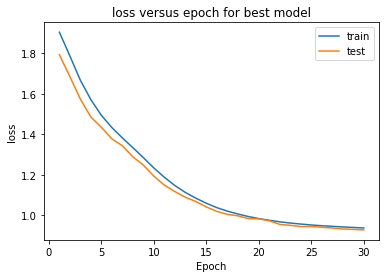

In [19]:
E = [i+1 for i in range(EPOCHS)]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(E, best_model_train_loss, color='tab:blue',label='train')
ax.plot(E, best_model_test_loss, color='tab:orange',label='test')
plt.legend(loc="upper right")
ax.set_title('loss versus epoch for best model')
ax.set_xlabel("Epoch")
ax.set_ylabel('loss')
plt.show()

As seen in the above chart, the cost function decreases during the learning process, indicating a descending trend. However, ultimately, this value cannot converge to less than one


---



---



---


It is noteworthy that overfitting did not occur for the network due to the trend of changes in the cost function observed on the two datasets

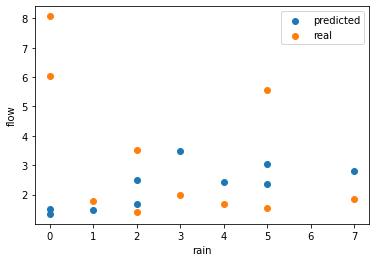

In [90]:
test2= test.sort_values(by=['Rain','Flow'])
indices =list(test2.index)
random_index = [i* 30 for i in range(75,85)]
selected =[indices[i] for i in random_index ]
test2 = test2.loc[selected]
X = torch.tensor(test2.drop(columns=['Flow']).values) 
y =(test2['Flow'])
predicted = best_model(X.float())
predicted = [tensor.item() for tensor in predicted]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(list(test2['Rain']),predicted , color='tab:blue',label='predicted')
ax.scatter(list(test2['Rain']), y, color='tab:orange',label='real')
plt.legend(loc="upper right")
# ax.set_title('flow based on rain')
ax.set_xlabel("rain")
ax.set_ylabel('flow')
plt.show()


In the above chart, the flow values are plotted against rainfall for several specific points to evaluate the performance of our method relative to the actual flow values

---


It should be noted that these points are selected in a way that we can assess the network's performance at points where rainfall and flow are not strongly correlated. The average error of our network is less than one. The high error in some points of the above chart does not necessarily indicate incorrect predictions with such large deviations for all points

---



---


If we focus on the first two points where the rainfall was zero, it can be observed that the flow values represent significantly higher amounts, which the neural network model has predicted with a relatively high error. From this observation, we can infer that the high flow rates on these days are likely not solely dependent on the rainfall on that day and the two days prior, and other parameters have contributed to the flow. 

In [79]:
test[test["Rain"]==0]

,Rain,Flow,yesterday_rain,two_days_ago
3461,0.0,1.83,0.0,0.0
5733,0.0,0.94,0.0,0.0
3467,0.0,2.33,0.0,0.0
7654,0.0,0.55,0.0,0.0
1983,0.0,1.68,0.0,3.0
...,...,...,...,...
10381,0.0,1.23,0.0,0.0
8997,0.0,1.62,0.0,0.0
3210,0.0,1.74,0.0,0.0
6053,0.0,3.20,0.0,0.0
